In [1]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from scipy.stats import norm
import statsmodels.stats.api as sms

from matplotlib import animation, rc
from IPython.display import HTML

plt.rc('text', usetex=True)
plt.rc('font', family='serif')


Suppose we are given a set of data and we know it is created from a logistic eqution-style differential equation.
 We want to estimate the parameter $\lambda$ from the data. First, we know the form of the solution of the differential equation, namely : $$ x = \frac{Ce^{rt}}{1 + \frac{C}{K}e^{rt}} $$.

When the differential equation takes the form of : $$\frac{dx}{dt} = rx(1 - \frac{x}{K}) $$


We  by simplifying the equation, setting the growth rate factor $r = 0$. This gives our differential equation in the form : $$ \frac{dx}{dt} = \lambda x(1 - x) $$


Now, we assume that the data follows the solution to the equation above but with added random noise. For this, I will assume that the noise, $ \epsilon_{i}$ follows a normal distribution, $\epsilon_{i} \sim N(0, \sigma^{2})$. 

This then gives us our data as a random variable: $$ x_i = C \frac{ e^{\lambda t_i} }{1 + e^{\lambda t_i}} + \epsilon_i     \quad \quad for \quad i = 1,2, ..., n $$

We will simulate our data so that $C = 1 $

# Simulating Data

In [2]:
random.seed(2018)
np.random.seed(6)
true_lambda = random.random()

t_values = np.linspace(-5,15,51)
print(len(t_values))


def diff_eqn_solution(true_lambda, t):
    return np.exp(true_lambda*t)/(1 + np.exp(true_lambda*t))

51


In [3]:
# Simulating what the true solution would be then adding the simulated gaussian noise 

sim_df = pd.DataFrame(index=t_values)
sim_df["true_values"] = diff_eqn_solution(true_lambda, sim_df.index)
sim_df["sim_values"] = np.zeros(len(sim_df.index))

sigma = 0.07

for index, row in sim_df.iterrows():
    sim_df.loc[index, "sim_values"] = sim_df.loc[index, "true_values"] + np.random.normal(0, sigma)

In [4]:
sim_df.head()

,true_values,sim_values
-5.0,0.065022,0.043198
-4.6,0.079254,0.130284
-4.2,0.096280,0.111527
-3.8,0.116500,0.053564
-3.4,0.140308,-0.033767


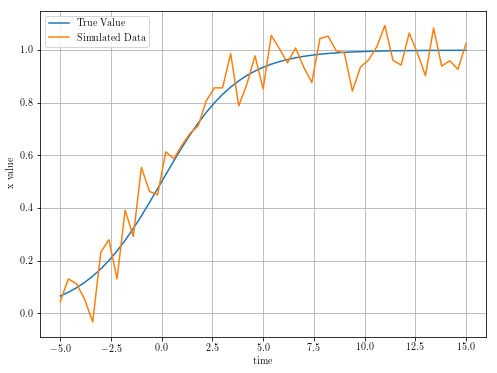

In [5]:
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 8
fig_size[1] = 6

plt.plot(sim_df["true_values"])
plt.plot(sim_df["sim_values"])
plt.grid(True)
plt.xlabel("time")
plt.ylabel("x value")
plt.legend(["True Value", "Simulated Data"])
plt.show()

My prior distribution is unbiased for $\lambda$. This means we will have a uniform distribution prior, similar to that of the coin toss example.

Prior : $$ \lambda  \in [0,1] $$

In [6]:
dist_index = np.linspace(0, 1, 101)
lambda_df = pd.DataFrame(index=dist_index[:-1])
lambda_df = lambda_df.drop(lambda_df.tail(2))
lambda_df["prior_dist"] = [0.01] * len(lambda_df.index)

In [7]:
lambda_df.head()

,prior_dist
0.00,0.01
0.01,0.01
0.02,0.01
0.03,0.01
0.04,0.01


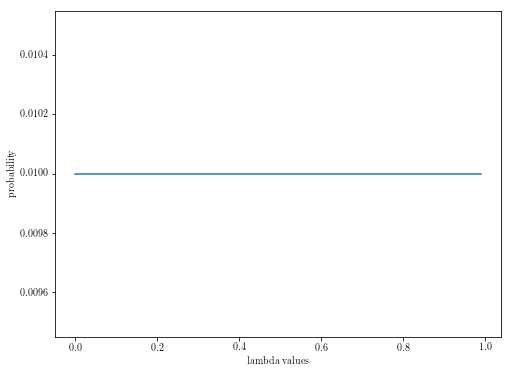

In [8]:
plt.plot(lambda_df)
plt.xlabel("lambda values")
plt.ylabel("probability")
plt.show()

# Bayesian Inference

Likelihood 

We need to now caluculate the likelihood probability so that we can then calucalte the posterior, where the likelihood probability is: $$ Pr(d \mid \theta) $$ Where $d$ is our simulated data and $\theta$ is the possible values for $\lambda$.



I will start by considering the case where we update our beliefs as time goes on and so for our likelihood distribution for a given $\theta$ and $t$, we have:
$$ \text{Pr}(d(t) \mid \theta) = \text{Pr}(X(\theta, t) = \text{sim_val(t)}), \quad \text{where} \quad X \sim N(f(\theta, t), 0.02) \quad \text{and} \quad f(\theta, t) = \frac{ e^{\lambda t_i} }{1 + e^{\lambda t_i}} $$

In [9]:
def prob_density_norm(x, mean, sigma):
    return np.exp(-(pow((x-mean), 2))/2.0*pow(sigma,2))/(np.sqrt(2.0*np.pi)*sigma)


def likelihood_dist_func(sim_value, test_lambda, t):
    return norm.pdf(sim_value,  expect_value(test_lambda, t), sigma)


def expect_value(test_lambda, t):
    return np.exp(test_lambda*t)/(1 + np.exp(test_lambda*t))


for i in range(len(sim_df.index)):
    for index, row in lambda_df.iterrows():
        lambda_df.at[index, "likelihood"] = likelihood_dist_func(sim_df["sim_values"].iloc[i], index, sim_df.index[i])
    evidence_term = sum(lambda_df["likelihood"] * lambda_df["prior_dist"])
    lambda_df["prior_dist"] = lambda_df["prior_dist"] * lambda_df["likelihood"] / evidence_term
    #print("Completed " + str(i + 1) + " out of " + str(len(sim_df.index)))



Posterior:

Using Bayes Equation, we can calculate the Posterior distribution from the Likelihood and Prior: $$ Pr(\theta \mid d) = \frac{Pr(d \mid \theta)  Pr(\theta)}{Pr(d)} $$. I have approximated the evidence term, $Pr(d)$, by summing the product of the likelihood and the prior probability, as seen below.

$$ Pr(d) = \int Pr(d \mid \theta) f(\theta) \: d\theta \approx \sum_{i=0}^{n} Pr(d \mid \theta)f(\theta) \cdot 0.01$$

Here our "prior_dist" column represents the probability of lambda falling within that range. 

$$ \text{"prior_dist"} = f(\theta) * \text{interval_width}  \quad , \text{where interval_width}  = 0.01$$

In [10]:
lambda_df

,prior_dist,likelihood
0.00,0.000000e+00,3.561393e-12
0.01,0.000000e+00,1.700064e-10
0.02,1.629697e-305,5.868067e-09
0.03,1.080566e-277,1.429501e-07
0.04,7.101552e-252,2.433167e-06
0.05,4.501143e-228,2.902653e-05
0.06,2.946610e-206,2.461694e-04
0.07,2.312525e-186,1.518478e-03
0.08,2.689755e-168,7.011194e-03
0.09,5.996562e-152,2.501945e-02


In [11]:
sum(lambda_df.prior_dist)

0.9999999999999992

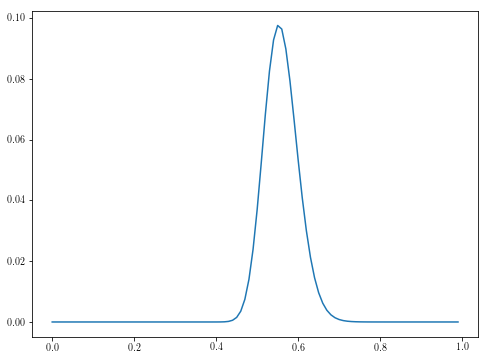

In [12]:
plt.plot(lambda_df.prior_dist)
plt.show()

# Analysis

Now we can identify a 95% probability interval, $H$, for our $\lambda$such that: $$ \text{Pr}(\lambda \in H) \approx 0.95 $$

In [13]:
confid_int = sms.DescrStatsW(lambda_df["prior_dist"]).tconfint_mean()

analysis_df = lambda_df[lambda_df["prior_dist"] > confid_int[0]]

In [14]:
analysis_df

,prior_dist,likelihood
0.47,0.007462,5.329279
0.48,0.014056,5.332636
0.49,0.023916,5.335516
0.50,0.037010,5.337987
0.51,0.052423,5.340108
0.52,0.068378,5.341929
0.53,0.082587,5.343493
0.54,0.092845,5.344837
0.55,0.097626,5.345993
0.56,0.096447,5.346986


In [15]:
sum(analysis_df.prior_dist)

0.9847311133187197

In [16]:
H = [analysis_df.index[0], analysis_df.index[-1]]

min_data = pd.DataFrame(index = sim_df.index)
max_data = pd.DataFrame(index = sim_df.index)

min_data["min_val"] = expect_value(H[0], sim_df.index)
max_data["max_val"] = expect_value(H[1], sim_df.index)

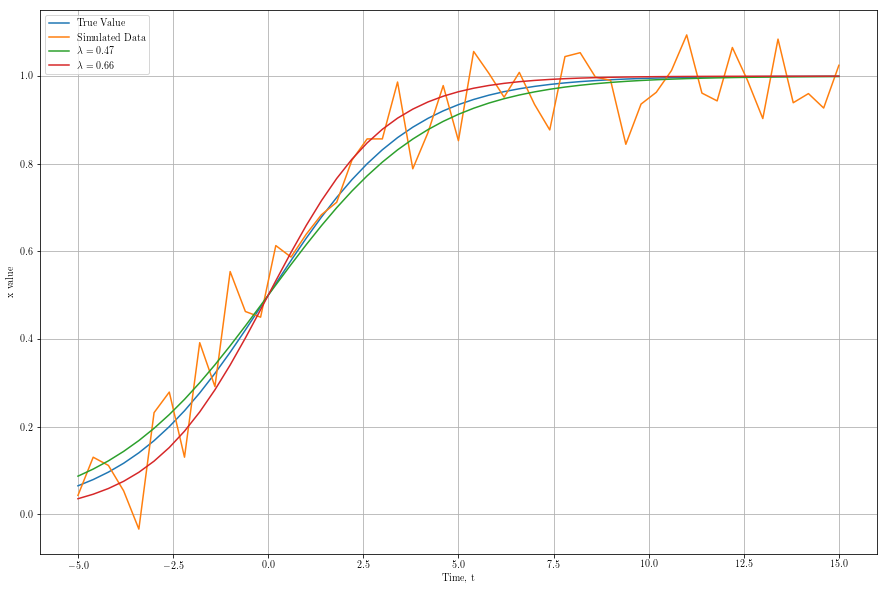

In [17]:
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 15
fig_size[1] = 10

plt.plot(sim_df["true_values"])
plt.plot(sim_df["sim_values"])
plt.plot(min_data["min_val"])
plt.plot(max_data["max_val"])
plt.grid(True)
plt.xlabel("Time, t")
plt.ylabel("x value")
plt.legend(["True Value", "Simulated Data", r'$\lambda =' +  str(round(H[0], 2)) + '$', r'$\lambda = ' +  str(round(H[1], 2)) + '$'])
plt.show()

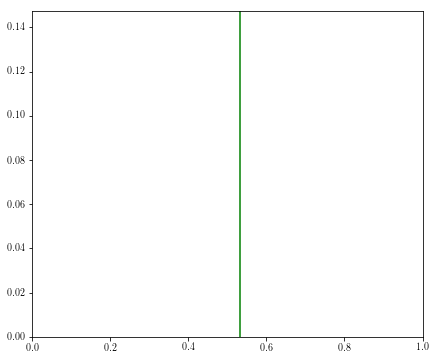

In [18]:
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 7
fig_size[1] = 6

fig, ax = plt.subplots()

ax.set_xlim(( -0, 1))
ax.set_ylim((-0, analysis_df["prior_dist"].max() + 0.05))
ax.axvline(true_lambda, color ="g")

line, = ax.plot([], [], lw=2)

In [19]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [20]:
#refreshing all our data from the beginning so we can see how it progressed as the data was fed into it.

lambda_df = pd.DataFrame(index=dist_index[:-1])
lambda_df = lambda_df.drop(lambda_df.tail(2))
lambda_df["prior_dist"] = [0.01] * len(lambda_df.index)



# animation function. This is called sequentially
def animate(i):
    if i== 0:
        x = lambda_df.index
        y = lambda_df["prior_dist"]
        line.set_data(x, y)
        return (line,)
    
    else :
        x = lambda_df.index
        for index, row in lambda_df.iterrows():
            lambda_df.at[index, "likelihood"] = likelihood_dist_func(sim_df["sim_values"].iloc[i], index, sim_df.index[i])
        evidence_term = sum(lambda_df["likelihood"] * lambda_df["prior_dist"])
        lambda_df["prior_dist"] = lambda_df["prior_dist"] * lambda_df["likelihood"] / evidence_term

        y = lambda_df["prior_dist"]
        line.set_data(x, y)
        return (line,)

In [21]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=51, interval=200, blit=True)

In [22]:
HTML(anim.to_html5_video())

In [23]:
print(true_lambda)

0.5331579307274593


# Experiment Repeatablity

Lets consider that we repeat this test several times and instead of $\lambda$ having one true fixed value, it takes a value within a small range, say,  $ \lambda \: \in \: [0.5, 0.55]$.

Each experiment will draw a lambda from this range uniformly and we will have simulate the data in the same way. From here we then can perform the same inference for each individual experiment and take an average of our distributions.

For experiment, $E_i$ where $i = 1,2,...,n$ :

$$ \lambda_i \sim \text{Uniform}(0.5, 0.55) $$

In [24]:
lambda_range = [0.5, 0.55]

lambda_dataframes = {}

#run the experiment 10 times
#here we have to create 10 new simualted dataframes with a lambda drawn from range and then perform the same inference
#the resulting dataframe distributions will be saved to a dictionary.
for num in range(10):

    true_lambda = np.random.uniform(lambda_range[0], lambda_range[1])
    sim_df = pd.DataFrame(index=t_values)
    sim_df["true_values"] = diff_eqn_solution(sim_df.index)
    sim_df["sim_values"] = np.zeros(len(sim_df.index))
    
    for index, row in sim_df.iterrows():
        sim_df.loc[index, "sim_values"] = sim_df.loc[index, "true_values"] + np.random.normal(0, sigma)
    
    dist_index = np.linspace(0, 1, 101)
    lambda_df = pd.DataFrame(index=dist_index[:-1])
    lambda_df = lambda_df.drop(lambda_df.tail(2))
    lambda_df["prior_dist"] = [0.01] * len(lambda_df.index)
    
    for i in range(len(sim_df.index)):
        for index, row in lambda_df.iterrows():
            lambda_df.at[index, "likelihood"] = likelihood_dist_func(sim_df["sim_values"].iloc[i], index, sim_df.index[i])
        evidence_term = sum(lambda_df["likelihood"] * lambda_df["prior_dist"])
        lambda_df["prior_dist"] = lambda_df["prior_dist"] * lambda_df["likelihood"] / evidence_term
    
    lambda_dataframes[num] = lambda_df
    

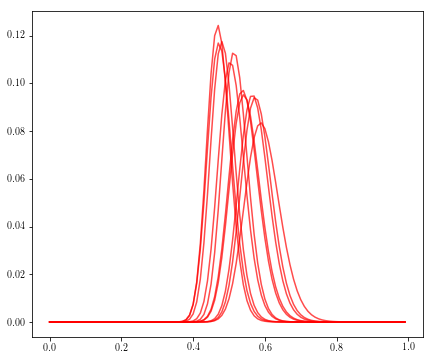

In [25]:
for i in range(len(lambda_dataframes)):
    plt.plot(lambda_dataframes[i]["prior_dist"], color = "red", alpha = 0.7)

In [26]:
average_df = lambda_dataframes[0].copy()

for i in range(1, len(lambda_dataframes)):
    average_df = average_df + lambda_dataframes[i]

In [27]:
average_df = average_df / len(lambda_dataframes)

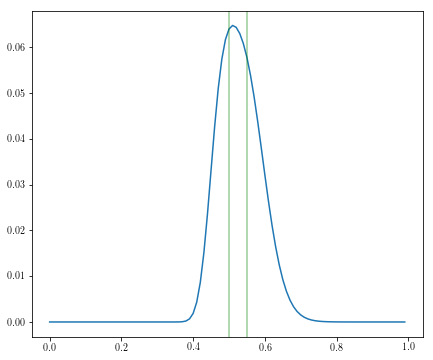

In [28]:
plt.plot(average_df.prior_dist)
plt.axvline(0.5, color = "g", alpha = 0.4)
plt.axvline(0.55, color = "g", alpha = 0.4)
plt.show()

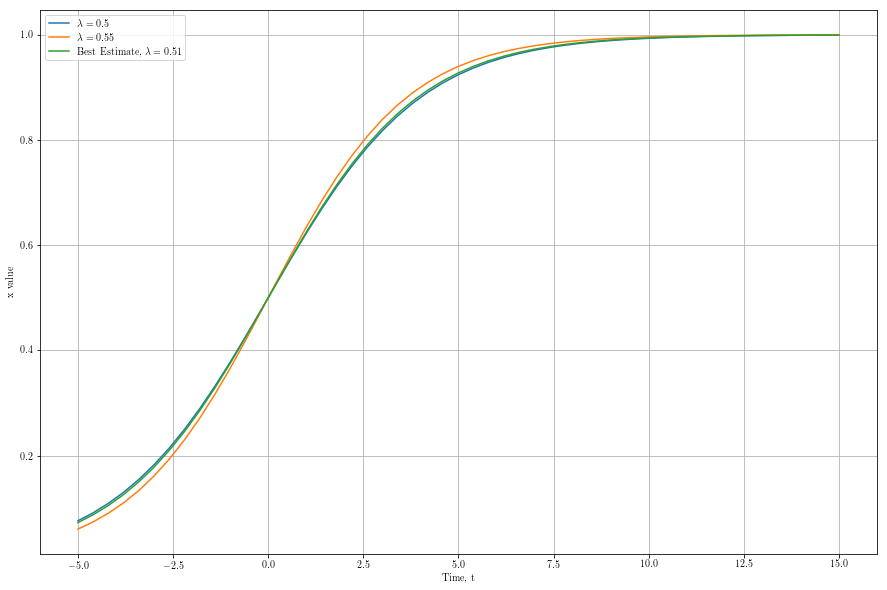

In [37]:
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 15
fig_size[1] = 10

sim_df_05 = pd.DataFrame(index=t_values)
sim_df_05["true_values"] = expect_value(0.5, sim_df.index)

sim_df_055 = pd.DataFrame(index=t_values)
sim_df_055["true_values"] = expect_value(0.55, sim_df.index)

max_lambda = average_df[average_df["prior_dist"] == average_df["prior_dist"].max()].index[0]

exp_distribution =  pd.DataFrame(index=t_values)
exp_distribution["true_values"] = expect_value(max_lambda, sim_df.index)


plt.plot(sim_df_05["true_values"])
plt.plot(sim_df_055["true_values"])
plt.plot(exp_distribution["true_values"])
plt.grid(True)
plt.xlabel("Time, t")
plt.ylabel("x value")
plt.legend([r'$\lambda =' +  str(0.5) + '$', r'$\lambda = ' +  str(0.55) + '$', r'Best Estimate, $\lambda = ' +  str(round(max_lambda, 2)) + '$'])
plt.show()